# Compute NDVI using Planet's 3 meter imagery

## Use Python libraries rasterio and numpy to manipulate and analyze 4-band imagery

In [124]:
import os
os.chdir('/Users/DHA/PycharmProjects/Planet/planet_order_63736/20170501_181313_0e1f'); print(os.listdir())
import rasterio
import copy
from xml.dom import minidom

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

['20170501_181313_0e1f_3B_AnalyticMS.tif', '20170501_181313_0e1f_3B_AnalyticMS_DN_udm.tif', '20170501_181313_0e1f_3B_AnalyticMS_metadata.xml', '20170501_181313_0e1f_metadata.json', 'ndvi_cmap.png']


## Read in Blue, Green, Red, and Near-Infrared Bands

In [111]:
image_file ='20170501_181313_0e1f_3B_AnalyticMS.tif'

with rasterio.open(image_file) as src:
   B, G, R, N = src.read()

## Adjust bands according to specifications in the metadata

In [112]:
xmldoc = minidom.parse("20170501_181313_0e1f_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

In [113]:
# Multiply Red and Near-Infrared bands by respective TOA Reflectance coefficients
band_red = R * coeffs[3]
band_nir = N * coeffs[4]

## Compute NDVI using band algebra

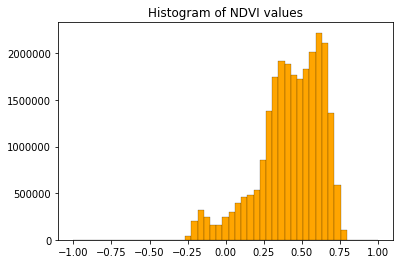

In [115]:
#suppress numpy errors to enable division by zero
np.seterr(divide='ignore',invalid='ignore')

#Compute the Normalized Difference Vegetation Index (NDVI)
# (N-R)/(N+R)
ndvi = (band_nir.astype(float) - band_red.astype(float))/ (band_nir + band_red)

#plot histogram of NDVI values
bins = np.linspace(-1,1,num=50)
plt.hist(ndvi[np.isfinite(ndvi)],bins=bins,color = 'orange', edgecolor = 'black', lw =0.2);
plt.title('Histogram of NDVI values');

In [116]:
#report summary NDVI statistics
print('NDVI statistics --> min: %f, max: %f, mean: %f, median: %f' % (np.nanmin(ndvi),np.nanmax(ndvi),np.nanmean(ndvi), np.nanmedian(ndvi)))

NDVI statistics --> min: -0.634254, max: 1.000000, mean: 0.428583, median: 0.455978


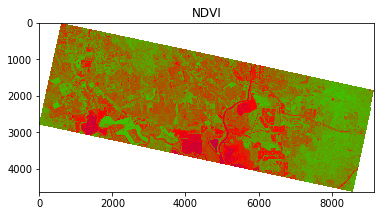

In [117]:
plt.imshow(ndvi,cmap='brg')
plt.clim(-1,1)
plt.title('NDVI');
matplotlib.pyplot.show()

## Set NDVI threshold to differentiate between vegetation and other land cover types

In [119]:
veg = copy.deepcopy(ndvi)
ndvi_threshold = 0.6
veg[ndvi < ndvi_threshold] = np.nan

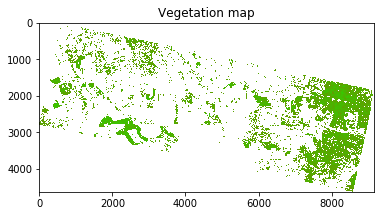

In [120]:
plt.imshow(veg,cmap='brg')
plt.clim(-1,1)
plt.title('Vegetation map')
matplotlib.pyplot.show()

## Plot continuous NDVI image alongside vegetation mask

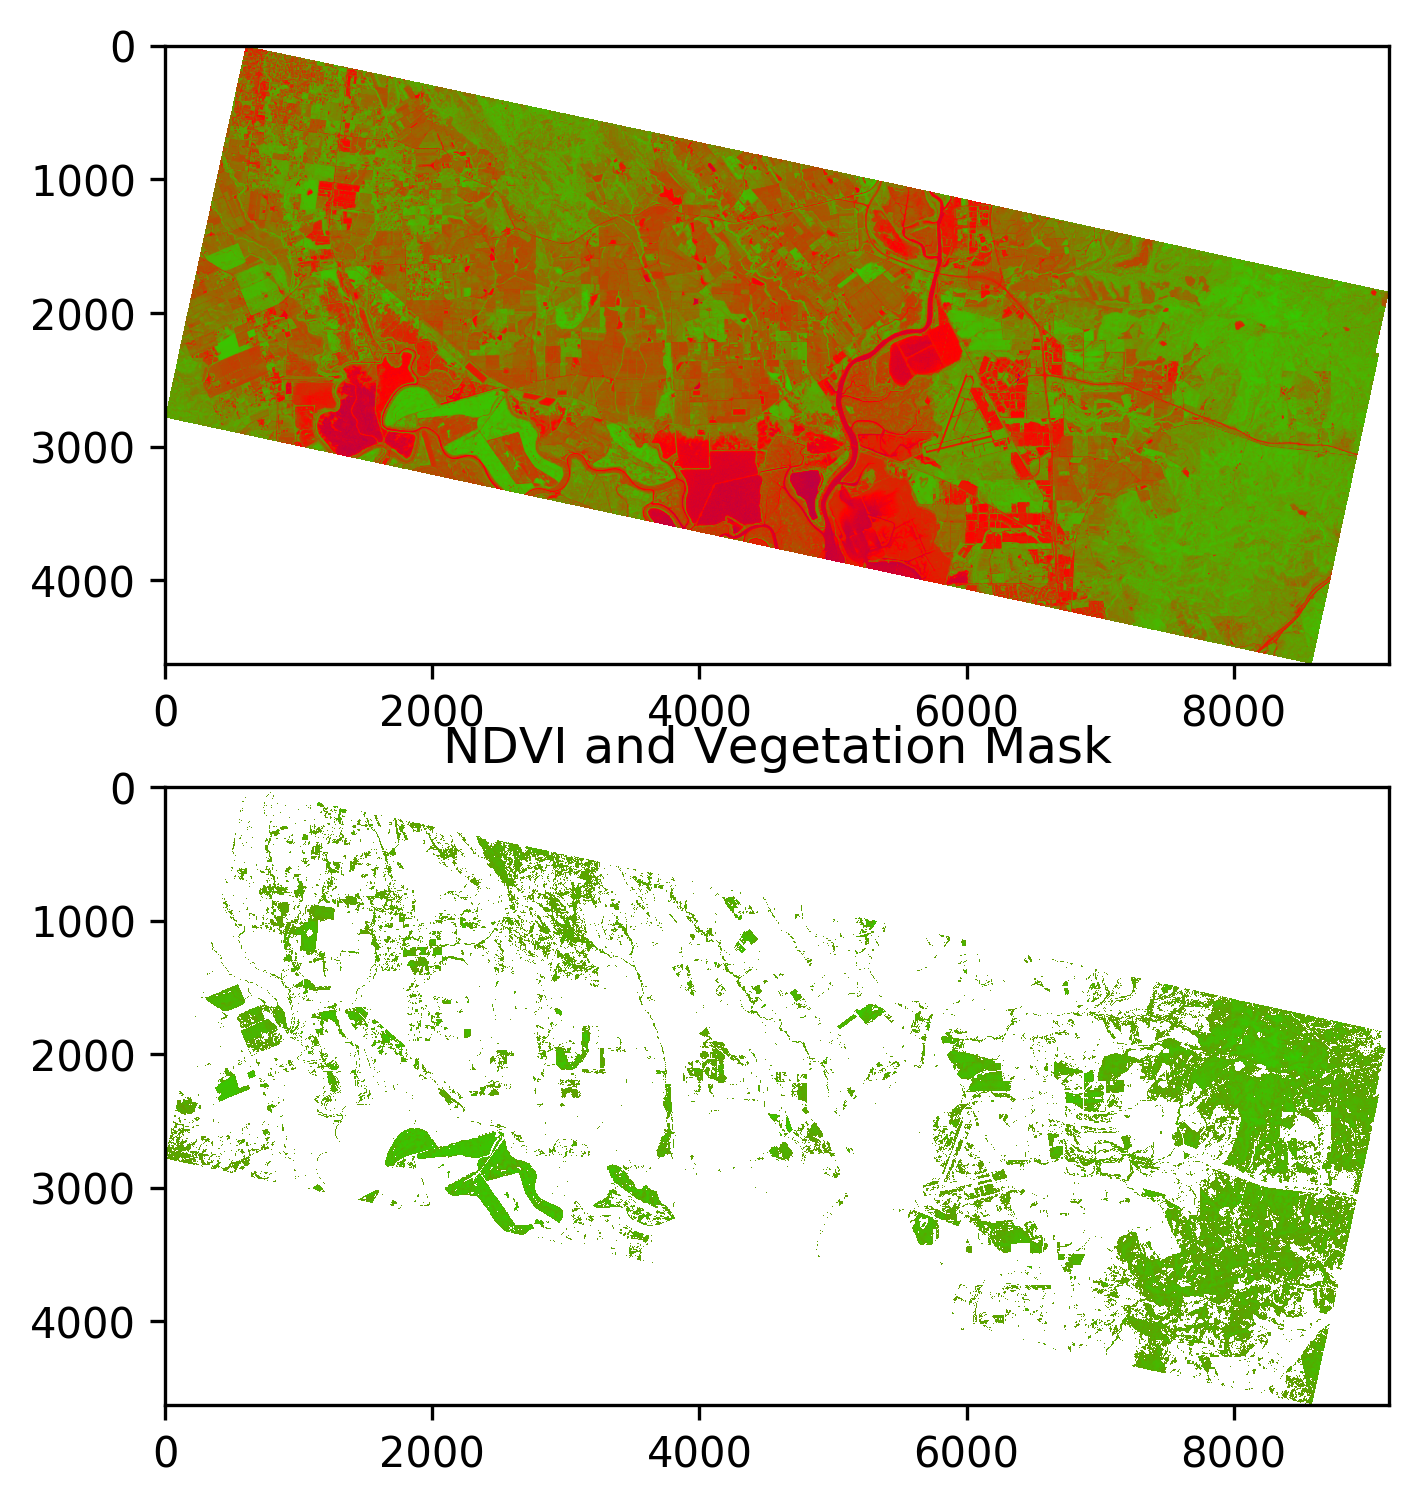

In [125]:
#plot full NDVI image alongside vegetation mask
plt.figure(1, figsize=(8,6),dpi=300)
plt.subplot(211)
plt.imshow(ndvi, cmap = 'brg',clim = [-1,1])
plt.subplot(212)
plt.imshow(veg,cmap = 'brg',clim=[-1,1])
plt.title('NDVI and Vegetation Mask')
matplotlib.pyplot.show()

## Assess total vegetated area

In [126]:
def vegetated_area(img, threshold):
    resolution = 3
    pix_sqm = pow(resolution,2)
    sqm_to_acres = 0.000247105
    veg_mask = np.where(img > threshold, 1, 0)
    pix_acres = veg_mask.sum()*pix_sqm * sqm_to_acres
    print('Acreage of vegetated area using %f threshold: %d' % (threshold, pix_acres))

In [127]:
vegetated_area(ndvi, 0.6)

Acreage of vegetated area using 0.600000 threshold: 13254
